In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
from sklearn.linear_model import LinearRegression

df_original = pd.read_excel('data-5features-all-outputs.xlsx')
df_all = pd.read_excel('All_data_correct.xlsx')
df_all.drop(columns=["Responsibility", "Listening_skills", "Questioning_skills", "Team_participation", "Teamwork_oriented"], inplace=True)
df = df_original.iloc[:,2:]

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# I have selected the other 4 outputs variables to predict the final target, team climate.
target = df.iloc[:,-1:]
variables = df.iloc[:,5:9]
bigfive = df.iloc[:, :5]
big_five_names = list(df.columns[:5])

all_personality = df_all.iloc[:,9:44]
personality_names = list(df_all.iloc[:, 9:44])
numerical_features = df_all.iloc[:, 9:]
numerical_features_names = list(df_all.iloc[:, 9:])

# Normalisation of the data
df_all[numerical_features_names] = (numerical_features - numerical_features.min())/(numerical_features.max()-numerical_features.min())

In [3]:
team_ids = df_all['Team ID'].unique()

# The team ids are splitted into training and testing
train_teams, test_teams = train_test_split(team_ids, test_size=0.2)

train_df = df_all[df_all['Team ID'].isin(train_teams)]
test_df = df_all[df_all['Team ID'].isin(test_teams)]
target_name = 'Team_Climate'

In [4]:
aux = train_df.iloc[:, 9:].drop(big_five_names, axis=1)
all_personality = list(aux.iloc[:, :30])
all_targets = list(aux.iloc[:, 30:34])

X_train_s = train_df[big_five_names]
X_train_a = train_df[all_personality]
X_test_s = test_df[big_five_names]
X_test_a = test_df[all_personality]
y_train_s = train_df[target_name]
y_train_a = train_df[target_name]
y_test_s = test_df[target_name]
y_test_a = test_df[target_name]

In [30]:
rft = RandomForestRegressor(max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42).fit(X_train_a, y_train_a)
y_pred = rft.predict(X_test_a)
test_score = rft.score(X_test_a, y_test_a)
train_score = rft.score(X_train_a, y_train_a)
mse = mean_squared_error(y_test_a, y_pred)
r2 = r2_score(y_test_a, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f"Test score: {test_score}")
print(f"Train score: {train_score}")

Mean Squared Error: 0.02292811825537556
R^2 Score: -0.006908331708599613
Test score: -0.006908331708599613
Train score: 0.7273801250847114


In [31]:
rft = RandomForestRegressor(max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42).fit(X_train_s, y_train_s)
y_pred = rft.predict(X_test_s)
test_score = rft.score(X_test_s, y_test_s)
train_score = rft.score(X_train_s, y_train_s)
mse = mean_squared_error(y_test_s, y_pred)
r2 = r2_score(y_test_s, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f"Test score: {test_score}")
print(f"Train score: {train_score}")

Mean Squared Error: 0.02221165547213746
R^2 Score: 0.024555756960449093
Test score: 0.024555756960449093
Train score: 0.629395828309783


There is an overfitting because the model performs well on the training data, obtaining a low error and performs poorly on the test data. (Low bias, high variance)
A main cause might be the insufficient amount of training data to represent the underlying distribution properly.

In [15]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error').fit(X_train_a, y_train_a)
print(f'Best Parameters: {grid_search.best_params_}')

best_rf = grid_search.best_estimator_
best_rf.fit(X_train_a, y_train_a)
y_pred = best_rf.predict(X_test_a)

# Evaluate the model
mse = mean_squared_error(y_test_a, y_pred)
r2 = r2_score(y_test_a, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Mean Squared Error: 0.023251214808976434
R^2 Score: -0.021097398955354008


In [33]:
rft_importances = pd.Series(rft.feature_importances_, index=list(bigfive)).sort_values()
rft_importances

Neuroticism          0.164125
Agreeableness        0.191148
Extraversion         0.193454
Conscientiousness    0.206738
Openness             0.244536
dtype: float64

In [125]:
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15]
}
dtr = DecisionTreeRegressor()
grid_search = GridSearchCV(dtr, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_s, y_train_s)
best_estimator = grid_search.best_estimator_
mse = mean_squared_error(y_test_s, y_pred)
rmse = mse ** 0.5
best_params = grid_search.best_params_
test_score = best_estimator.score(X_test_s, y_test_s)
train_score = best_estimator.score(X_train_s, y_train_s)

print(f"Best params: {best_params}")
print(f"Test score: {test_score}")
print(f"Train score: {train_score}")
print(f"RMSE: {rmse}")


Best params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 15}
Test score: -0.12871282374942372
Train score: 0.2955039826248951
RMSE: 0.22655936987670644


In [34]:
test_score = 0
train_score = 0
loop = 30
for i in range(loop):
    train_teams, test_teams = train_test_split(team_ids, test_size=0.2)
    train_df = df_all[df_all['Team ID'].isin(train_teams)]
    test_df = df_all[df_all['Team ID'].isin(test_teams)]
    
    X_train_s = train_df[big_five_names]
    X_test_s = test_df[big_five_names]
    y_train_s = train_df[target_name]
    y_test_s = test_df[target_name]
    
    dtr = DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=15, random_state=42)
    dtr.fit(X_train_s, y_train_s)
    y_pred = dtr.predict(X_test_s)
    test_score += dtr.score(X_test_s, y_test_s)
    train_score += dtr.score(X_train_s, y_train_s)
    
print(test_score/loop)
print(train_score/loop)

-0.29600839137283685
0.3410553378857118


In [35]:
neigh = KNeighborsRegressor(n_neighbors=10).fit(X_train_a, y_train_a)
# predictions = neigh.predict(X_test_s)
test_score = neigh.score(X_test_a, y_test_a)
train_score = neigh.score(X_train_a, y_train_a)

print(f"Test score: {test_score}")
print(f"Train score: {train_score}")

Test score: -0.13784969698218386
Train score: 0.12136083812610876


In [36]:
neigh = KNeighborsRegressor(n_neighbors=10).fit(X_train_s, y_train_s)
# predictions = neigh.predict(X_test_s)
test_score = neigh.score(X_test_s, y_test_s)
train_score = neigh.score(X_train_s, y_train_s)

print(f"Test score: {test_score}")
print(f"Train score: {train_score}")

Test score: -0.5385458338138358
Train score: 0.21529868751941106


In [37]:
gbc = GradientBoostingRegressor(n_estimators=100, learning_rate=1, max_depth=1, random_state=42).fit(X_train_a, y_train_a)
test_score = gbc.score(X_test_a, y_test_a)
train_score = gbc.score(X_train_a, y_train_a)

print(f"Test score: {test_score}")
print(f"Train score: {train_score}")

Test score: -0.6733281622598914
Train score: 0.797218258430312


In [38]:
gbc = GradientBoostingRegressor(n_estimators=100, learning_rate=1, max_depth=1, random_state=42).fit(X_train_s, y_train_s)
test_score = gbc.score(X_test_s, y_test_s)
train_score = gbc.score(X_train_s, y_train_s)

print(f"Test score: {test_score}")
print(f"Train score: {train_score}")

Test score: -0.8953410152440315
Train score: 0.5150923568045229


Better understanding of the possible error, data visualisation, dimensionality reduction to visualise the difficulty of learning a function that predicts well.
Create several training and testing split and get the average to get a better estimation of the performance.

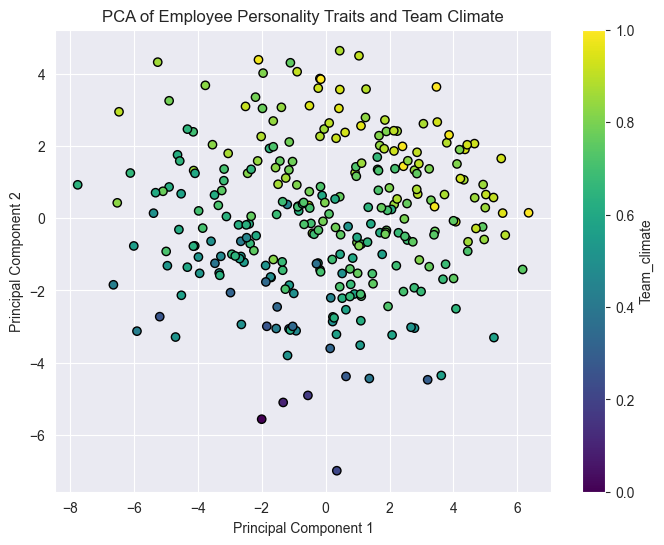

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


df_pca = df_all.iloc[:, 9:]
target = df_pca['Team_Climate']
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(df_pca))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Team_Climate'] = target.values

plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Team_Climate'], cmap='viridis', edgecolor='k')
plt.colorbar(scatter, label='Team_climate')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Employee Personality Traits and Team Climate')
plt.savefig('PCA.png')

plt.show()

In [6]:
from sklearn.metrics import accuracy_score

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_result, target, test_size=0.2, random_state=42)

# Training a Logistic Regression model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = model.score(y_test, y_pred)
print("Accuracy:", accuracy)


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

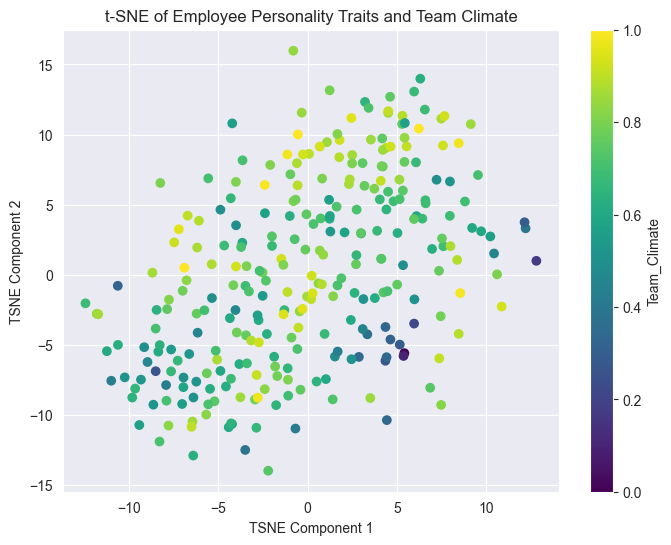

In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2 ,perplexity=30, max_iter=300, learning_rate=100, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)

tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['Team_Climate'] = target.values

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['Team_Climate'], cmap='viridis')
plt.colorbar(scatter, label='Team_Climate')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE of Employee Personality Traits and Team Climate')
plt.savefig('TSNE.png')
plt.show()